## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms as T
from avalanche.training import Naive, Replay  # , plugins
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting, models
from src.strategies import LatentReplay, GenerativeLatentReplay


Problem definition

In [2]:
# Dataset specific attributes
dataset = PermutedMNIST
n_experiences = 3

Setup

In [3]:
# Reproducibility
SEED = 109
utils.set_seed(SEED)


Hyperparameters

In [4]:
# Replays
replay_buffer_size = 500

# Frozen backbone
freeze_depth = 2
latent_layer_number = freeze_depth * 3

# Generic hyperparams
lr = 0.001
l2 = 0.0005
momentum = 0.9

strategy_kwargs = {
    "train_epochs": 20,
    "train_mb_size": 128,
    "eval_mb_size": 512,
    "device": utils.get_device(),
    "plugins": None, # [plugins.EarlyStoppingPlugin(patience=1, val_stream_name="train_stream")]  # JA: need to set params
    "eval_every": -1,
}

In [5]:
# Model specification
model = "mlp"

model_kwargs = {
    "drop_rate": 0,
    "num_classes": 10,
    "hidden_size": 100,
    "hidden_layers": 2,
}


Building base model

In [6]:
# Model
n = 6

if model == "mlp":
    networks = [models.SimpleMLP(**model_kwargs) for i in range(n)]
    transform = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])

elif model == "cnn":
    networks = [models.SimpleCNN(**model_kwargs) for i in range(n)]
    transform = T.Compose([T.ToTensor()])

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Building Continual Learning methods for comparison

In [7]:
# Baseline
naive_strategy = Naive(
    model=networks[0],
    optimizer=SGD(networks[0].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    **strategy_kwargs,
)

# Benchmark - raw and latent replay
replay_strategy = Replay(
    model=networks[1],
    criterion=CrossEntropyLoss(),
    optimizer=SGD(networks[1].parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    **strategy_kwargs,
)

# Sanity check - should perform similar to "Replay"
# replay_thawed_strategy = LatentReplay(
#    model=networks[2],
#    latent_layer_num=0,
#    subsample_replays=True,
#    rm_sz=replay_buffer_size,
#    **strategy_kwargs,
# )

lat_replay_strategy = LatentReplay(
    model=networks[3],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    subsample_replays=True,
    **strategy_kwargs,
)

gen_replay_strategy = GenerativeLatentReplay(
    model=networks[4],
    rm_sz=replay_buffer_size,
    latent_layer_num=0,
    **strategy_kwargs,
)

# Continual learning strategy
gen_lat_replay_strategy = GenerativeLatentReplay(
    model=networks[5],
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    **strategy_kwargs,
)

# print(gen_lat_replay_strategy.model)

In [17]:
strategies = {
    "Naive": {"model": naive_strategy, "results": []},
    #"Replay": {"model": replay_strategy, "results": []},
    #"Replay (re-imp)": {"model": replay_thawed_strategy, "results": []},
    "Latent Replay": {"model": lat_replay_strategy, "results": []},
    #"Generative Replay": {"model": gen_replay_strategy, "results": []},
    #"Generative Latent Replay": {"model": gen_lat_replay_strategy, "results": []},
}

Training loop

In [18]:
for strat in strategies.values():
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
        # rotations_list=[0, 60, 300],
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        strat["model"].train(train_exp)
        strat["results"].append(strat["model"].eval(train_stream))

-- >> Start of training phase << --
100%|██████████| 469/469 [00:32<00:00, 14.55it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.8118
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7767
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 118/118 [00:24<00:00,  4.73it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 0.5977
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.8393
-- Starting eval on experience 1 (Task 0) from train stream --
100%|██████████| 118/118 [00:28<00:00,  4.12it/s]
> Eval on experience 1 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp001 = 0.8848
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp001 = 0.7333
-- Starting eval on experience 2 (Task 0) from train stream --
100%|██████████| 118/118 [00:24<00:00,  4.77it/s]
> Eval on experience 2 (Task

Plotting

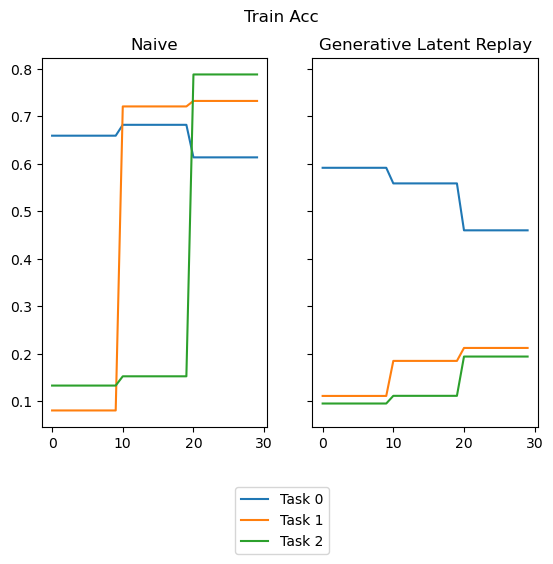

In [10]:
results = [s["results"] for s in strategies.values()]

plotting.plot_multiple_results(results, strategies.keys(), n_experiences)

In [16]:
import importlib
importlib.reload(utils)

utils.results_to_df(strategies.keys(), results)

,Final Avg Acc
Naive,0.711156
Generative Latent Replay,0.288689
